# Skincancer HAM-dataset med Pytorch

In [1]:
do_training = True

## Standardimporter

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
import torch.optim as optim
from torch.optim import lr_scheduler

import time
import os
from glob import glob
from PIL import Image

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Hantering av GPU och CPU:

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [4]:
device = get_default_device()

In [5]:
# print(device)

### De båda nedanstående blocken används för att enkelt flytta till GPU: 

In [6]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [7]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Hjälpfunktioner för att spara och ladda:

In [8]:
# Anropas när följande variabler finns tillgängliga:
# epochs, batchsz-{train, val}, learning_rate
# Dessa krävs för funktionen "create_filename".

def create_filename(filename):
    global file_name
    file_name = filename + "_e" + str(epochs) + "_bsztr" + str(batchsz_train) + \
            "_bszval" + str(batchsz_val) + "_lr" + str(f'{learning_rate:.0e}')
    return file_name

In [9]:
# https://pytorch.org/docs/master/notes/serialization.html

def save_trained_model(modelname):
    model_folder = "trained_models"
    model_file_suffix = ".pt"
    create_filename(modelname) # spottar ur sig ett filnamn i variabeln "file_name"
    
    full_model_filename = model_folder + "/" + file_name + model_file_suffix
    
    torch.save(model.state_dict(), full_model_filename)

In [10]:
def load_trained_model(modelname):
    model_folder = "trained_models"
    model_file_suffix = ".pt"
    create_filename(modelname) # spottar ur sig ett filnamn i variabeln "file_name"
    
    full_model_filename = model_folder + "/" + file_name + model_file_suffix
    
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(full_model_filename))
    else:
        model.load_state_dict(torch.load(full_model_filename, map_location=torch.device('cpu')))

In [11]:
def save_training_log(logname, do_validation = True):
    log_folder = "logs"
    log_filename = create_filename(logname)
    log_file_suffix = ".csv"
    full_log_filename = log_folder + "/" + file_name + log_file_suffix
        
    global training_log
        
    # Speciell range nedan för att starta på epok 1 och ej 0:
    if do_validation == True:
        training_log = pd.DataFrame(data={"epoch": range(1, epochs + 1), \
                                              "train_acc": train_accuracy, \
                                              "train_loss": train_losses,  \
                                              "val_acc": val_accuracy, \
                                              "val_loss": val_losses})
    
        training_log.to_csv(full_log_filename, sep=',', index = False)
    else:
        training_log = pd.DataFrame(data={"epoch": range(1, epochs + 1), \
                                              "train_acc": train_accuracy, \
                                              "train_loss": train_losses})
    
        training_log.to_csv(full_log_filename, sep=',', index = False)
    
    return training_log

In [12]:
def load_training_log(logname):
    log_folder = "logs"
    log_filename = create_filename(logname)
    log_file_suffix = ".csv"
    full_log_filename = log_folder + "/" + file_name + log_file_suffix
    
    global training_log
    training_log = pd.read_csv(full_log_filename)
    return training_log

## Definiera de olika mängderna för träning, validering och test:

In [13]:
epochs = 100
learning_rate = 1e-4

img_w = 224
img_h = 224
img_dim = 3

batchsz_train = 2**5
batchsz_val = 2**5
batchsz_test = 2**5

train_num_workers = 4
test_val_num_workers = 4

basepath = "../../../ml/Datasets/skin-cancer-mnist-ham10000/"
csvpath = "csv/"
imagepath = "images_per_label/"

orig_image_path = "../../../ml/Datasets/skin-cancer-mnist-ham10000/data_original"

In [14]:
# Läs in metadatat i en pandas:

ham_df = pd.read_csv(basepath + csvpath + "HAM10000_metadata.csv")

In [15]:
ham_df.head(n = 3)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp


In [16]:
ham_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [17]:
ham_features_df = ham_df[['lesion_id', 'image_id', 'age', 'sex', 'localization']]
ham_features_df.head(n = 3)

,lesion_id,image_id,age,sex,localization
0,HAM_0000118,ISIC_0027419,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,80.0,male,scalp


In [18]:
# Gör två dictionaries för bildernas namn <--> dess filnamn
# och en för ett fylligare namn på klasserna:

data_dir = orig_image_path

all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

imageid_path_dict
#lesion_type_dict

{'ISIC_0025781': '../../../ml/Datasets/skin-cancer-mnist-ham10000/data_original/HAM10000_images_part_1/ISIC_0025781.jpg',
 'ISIC_0026410': '../../../ml/Datasets/skin-cancer-mnist-ham10000/data_original/HAM10000_images_part_1/ISIC_0026410.jpg',
 'ISIC_0027762': '../../../ml/Datasets/skin-cancer-mnist-ham10000/data_original/HAM10000_images_part_1/ISIC_0027762.jpg',
 'ISIC_0025994': '../../../ml/Datasets/skin-cancer-mnist-ham10000/data_original/HAM10000_images_part_1/ISIC_0025994.jpg',
 'ISIC_0026638': '../../../ml/Datasets/skin-cancer-mnist-ham10000/data_original/HAM10000_images_part_1/ISIC_0026638.jpg',
 'ISIC_0025508': '../../../ml/Datasets/skin-cancer-mnist-ham10000/data_original/HAM10000_images_part_1/ISIC_0025508.jpg',
 'ISIC_0026404': '../../../ml/Datasets/skin-cancer-mnist-ham10000/data_original/HAM10000_images_part_1/ISIC_0026404.jpg',
 'ISIC_0024566': '../../../ml/Datasets/skin-cancer-mnist-ham10000/data_original/HAM10000_images_part_1/ISIC_0024566.jpg',
 'ISIC_0025057': '../../

In [19]:
df_original = pd.read_csv(os.path.join(basepath + "/csv", 'HAM10000_metadata.csv'))

In [20]:
df_original = pd.read_csv(os.path.join(basepath + "/csv", 'HAM10000_metadata.csv'))

df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)

df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)

df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes

df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../../../ml/Datasets/skin-cancer-mnist-ham1000...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../../../ml/Datasets/skin-cancer-mnist-ham1000...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../../../ml/Datasets/skin-cancer-mnist-ham1000...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../../../ml/Datasets/skin-cancer-mnist-ham1000...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../../../ml/Datasets/skin-cancer-mnist-ham1000...,Benign keratosis-like lesions,2


In [21]:
# this will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it:
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace = True)

df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [22]:
df_original.groupby('lesion_id').count()

,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
lesion_id,,,,,,,,,
HAM_0000000,2,2,2,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
HAM_0007624,1,1,1,1,1,1,1,1,1
HAM_0007625,2,2,2,2,2,2,2,2,2
HAM_0007626,1,1,1,1,1,1,1,1,1


In [23]:
# here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']

# apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../../../ml/Datasets/skin-cancer-mnist-ham1000...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../../../ml/Datasets/skin-cancer-mnist-ham1000...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../../../ml/Datasets/skin-cancer-mnist-ham1000...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../../../ml/Datasets/skin-cancer-mnist-ham1000...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../../../ml/Datasets/skin-cancer-mnist-ham1000...,Benign keratosis-like lesions,2,duplicated


In [24]:
# Se hur många bilder som har dubbletter eller ej:

df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [25]:
# now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [26]:
# now we create a val set using df because we are sure that none
# of these images have augmented duplicates in the train set:

# This stratify parameter makes a split so that the proportion 
# of values in the sample produced will be the same as the proportion
# of values provided to parameter stratify.

# For example, if variable y is a binary categorical variable 
# with values 0 and 1 and there are 25% of zeros and 75% of ones,
# stratify = y will make sure that your random split has 25% of 0's and 75% of 1's.


y_strat = df_undup['cell_type_idx']

_, df_val = train_test_split(df_undup, test_size = 0.2, random_state = 101, stratify = y_strat)

df_val.shape

(1103, 11)

In [27]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: cell_type_idx, dtype: int64

In [28]:
df_val.head(n = 2)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
4781,HAM_0000199,ISIC_0026127,nv,follow_up,55.0,male,lower extremity,../../../ml/Datasets/skin-cancer-mnist-ham1000...,Melanocytic nevi,4,unduplicated
3294,HAM_0006655,ISIC_0025994,nv,follow_up,50.0,female,lower extremity,../../../ml/Datasets/skin-cancer-mnist-ham1000...,Melanocytic nevi,4,unduplicated


In [29]:
# This set will be df_original excluding all rows that are in the val-set.
# This function identifies if an image is part of the train or val set:

def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    
    else:
        return 'train'

In [30]:
# identify train and val rows
# create a new colum that is a copy of the image_id column

df_original['train_or_val'] = df_original['image_id']


# apply the function to this new column

df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)


# filter out train rows

df_train = df_original[df_original['train_or_val'] == 'train']

print(len(df_train))
print(len(df_val))

8912
1103


In [31]:
df_train.head(n = 2)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates,train_or_val
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../../../ml/Datasets/skin-cancer-mnist-ham1000...,Benign keratosis-like lesions,2,duplicated,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../../../ml/Datasets/skin-cancer-mnist-ham1000...,Benign keratosis-like lesions,2,duplicated,train


In [32]:
df_train['cell_type_idx'].value_counts()

4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: cell_type_idx, dtype: int64

In [33]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

In [36]:
sum = df_train['dx'].value_counts().sum()

list_of_weights = []

arr_of_weights = np.zeros(0)


for num in df_train['dx'].value_counts():
    frac = np.divide(num, sum)
    arr_of_weights = np.append(arr_of_weights, frac)

arr_of_weights

array([0.65327648, 0.11972621, 0.11344255, 0.05374776, 0.03332585,
       0.01447487, 0.01200628])

In [38]:
arr_of_weights_rounded_int = np.floor(1000*arr_of_weights).astype(int)
arr_of_weights_int = arr_of_weights_rounded_int.astype(int)
arr_of_weights_rounded_int

array([653, 119, 113,  53,  33,  14,  12])

In [39]:
# Copy fewer class to balance the number of 7 classes

# Kan nedanstående räknas ut?
# data_aug_rate = [15, 10, 5, 50, 0, 40, 5]

# Ingen augmentation:

data_aug_rate = [0, 0, 0, 0, 0, 0, 0]
# data_aug_rate = arr_of_weights_rounded_int

for i in range(len(arr_of_weights_rounded_int)):
    if data_aug_rate[i]:
        df_train = df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)

df_train['cell_type'].value_counts()

Melanocytic nevi                  5822
dermatofibroma                    1067
Benign keratosis-like lesions     1011
Basal cell carcinoma               479
Actinic keratoses                  297
Vascular lesions                   129
Dermatofibroma                     107
Name: cell_type, dtype: int64

In [40]:
# # We can split the test set again in a validation set and a true test set:
# df_val, df_test = train_test_split(df_val, test_size=0.5)

df_train = df_train.reset_index()

df_val = df_val.reset_index()
# df_test = df_test.reset_index()

In [41]:
# Define a pytorch dataloader for this dataset
from torch.utils.data import Dataset, DataLoader

class ham10k(torch.utils.data.Dataset):
    def __init__(self, df, transform = None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        
        # Load data and get label
        X = Image.open(self.df['path'][index]) # returnernar en bild
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

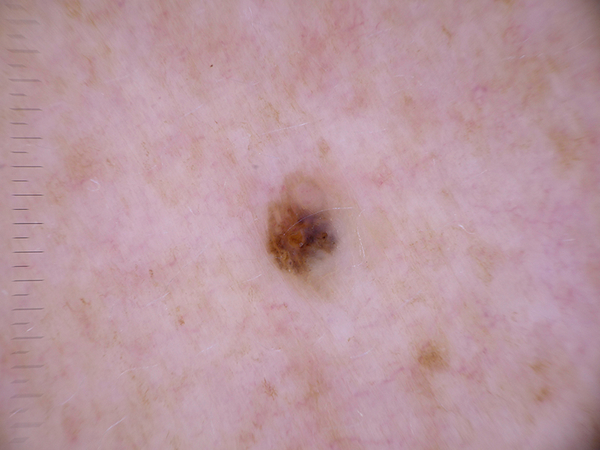

In [42]:
# Exempel på ovanstående:

index = 11
X = Image.open(df_train['path'][index])
y = torch.tensor(int(df_train['cell_type_idx'][index]))
X

In [43]:
y

tensor(2)

In [44]:
# Definiera vilken augmentation som ska göras:

train_data_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_w),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])

val_test_data_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_w),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        ])

In [45]:
# Define the training set using the table train_df and using our defined transitions (train_transform)

training_set = ham10k(df_train, transform = train_data_transform)

train_loader = DataLoader(training_set, 
                          batch_size = batchsz_train, 
                          shuffle = True, 
                          pin_memory = True,
                          drop_last = True,
                          num_workers = train_num_workers)


# Same for the validation set:
validation_set = ham10k(df_val, transform = val_test_data_transform)

val_loader = DataLoader(validation_set, 
                        batch_size = batchsz_val, 
                        shuffle = False, 
                        num_workers = test_val_num_workers)


In [46]:
training_set.__len__()

8912

In [47]:
# Definiera antalet klasser:

number_of_classes = 7

### Flytta *_loader till rätt device

In [48]:
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(val_loader, device)

## Definiera en modell:

In [49]:
# Nedanstående två rader måste göras oavsett träning eller ej:

#model = models.densenet201(pretrained = True, progress = True)

model = models.alexnet(pretrained = True, progress = True)

In [50]:
# Printa modellen för att se de sista FC-lagren som behöver bytas ut: 
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [51]:
models_last_fc_infeatures = 128
model_name = 'alexnet'

In [52]:
create_filename(model_name)

'alexnet_e100_bsztr32_bszval32_lr1e-04'

In [53]:
if do_training == True:
    
    for param in model.parameters():
        param.require_grad = False
    
    # Ersätt sista fc-lagret med rätt antal ut-klasser:
    # Gör alexnet lite mindre tungt i de sista lagren också...:
    
    model.classifier[1] = nn.Linear(in_features = 9216, out_features = 2048, bias = True)
    model.classifier[4] = nn.Linear(in_features = 2048, out_features = 512, bias = True)
    model.classifier[5] = nn.Linear(in_features = 512, out_features = 128, bias = True)
    model.classifier[6] = nn.Linear(in_features = 128, out_features = number_of_classes, bias = True)
    
else:
    model.classifier = nn.Linear(in_features = models_last_fc_infeatures, out_features = number_of_classes, bias = True)
    load_trained_model(model_name)
    model.eval()

In [54]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=2048, bias=True)
 

### Flytta modellen till GPU, om en sådan finns:

In [55]:
# Flytta modellen till rätt device:

to_device(model, device)

# Verifiera att modellen är på rätt device:
# True => modellen finns på GPU.

next(model.parameters()).is_cuda

True

In [56]:
trainableparameters = []

for param in model.parameters():
    # trainableparameters = param.numel()
    trainableparameters.append(param.numel())
    num_trainable_params = np.sum(trainableparameters)
    
print(f'Antalet träningsbara parametrar är {num_trainable_params:,} st.')

Antalet träningsbara parametrar är 22,461,767 st.


## Definiera loss-function och vilken metod för optimering som ska användas:

In [57]:
# Definiera loss-function och vilken optimerare som ska användas:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [58]:
# Decay LR by a factor of 0.1 every 3 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

## Följande återställer modellens vikter mellan olika körningar

In [59]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight.data)

## Overfit på en batch för att se att modellen är rimlig

In [106]:
if do_training == True:

    model.apply(weights_init)
    model.train()

    inputs, labels = next(iter(train_dl))
    inputs = inputs.to(device)
    labels = labels.to(device)

    criterion_check_onebatch = nn.CrossEntropyLoss()
    optimizer_check_onebatch = optim.Adam(model.parameters(), lr = learning_rate)

    model.train()
    for epoch in range(100):
        optimizer_check_onebatch.zero_grad()
        outputs = model(inputs)
        loss = criterion_check_onebatch(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer_check_onebatch.step()
        correct = torch.sum(preds == labels)
    
        if epoch%10 == 0:
            print(f'Epok {epoch:02}: ----- loss = {loss:4.4f} ----- accuracy = {correct}')
else:
    pass

Epok 00: ----- loss = 1.9204 ----- accuracy = 7
Epok 10: ----- loss = 1.8618 ----- accuracy = 7
Epok 20: ----- loss = 1.3672 ----- accuracy = 15
Epok 30: ----- loss = 1.1129 ----- accuracy = 20
Epok 40: ----- loss = 0.9069 ----- accuracy = 21
Epok 50: ----- loss = 0.7674 ----- accuracy = 23
Epok 60: ----- loss = 0.5112 ----- accuracy = 23
Epok 70: ----- loss = 0.3816 ----- accuracy = 25
Epok 80: ----- loss = 0.3173 ----- accuracy = 29
Epok 90: ----- loss = 0.3595 ----- accuracy = 28


# Träna och utvärdera modellen

In [60]:
def train_eval(epochs = 10, do_validation = True, training_dataloader = train_dl, validation_dataloader = valid_dl):

    # if ((do_training == False) and (do_validation == True)):
    #    print("Kan inte validera en modell som inte tränats.")
    # else:
    start_training_time = time.time()

    # Placeholders för att mäta modellen:
    global train_accuracy, train_losses, val_accuracy, val_losses
        
    train_accuracy = []
    train_losses = []
        
    val_accuracy = []
    val_losses = []

    for epoch in range(epochs):
        start_epoch_time = time.time()
        train_correct_pred_per_epoch = 0
        
        current_train_loss = 0.0
        current_train_corrects = 0
        
        # Träning ###########################################################
        # Sätt modellen i träningsläge:
        start_train_time = time.time()
        model.train()
        
        for inputs_train, labels_train in training_dataloader:
            train_predictions = model.forward(inputs_train)
            optimizer.zero_grad()
            
            train_loss = criterion(train_predictions, labels_train)
            train_loss.backward()
                
            optimizer.step()
                    
            #exp_lr_scheduler.step()
            #lr = exp_lr_scheduler.get_lr()
                
            # Nedan ger den mest troliga klassen:
            _, train_predicted = torch.max(train_predictions, 1)
    
            current_train_loss += train_loss.item() * batchsz_train
            current_train_corrects += torch.sum(train_predicted == labels_train.data)
        
        end_train_time = time.time()
        
        # Validering ########################################################
        # Sätt modellen i utvärderingsläge:
            
        if do_validation == True:
            start_eval_time = time.time()
            model.eval()
        
            current_val_loss = 0.0
            current_val_corrects = 0
        
            with torch.no_grad():
                
                inputs_val, labels_val = next(iter(validation_dataloader))
                val_predictions = model.forward(inputs_val)
                val_loss = criterion(val_predictions, labels_val)
                _, val_predicted = torch.max(val_predictions, 1)
                    
                current_val_loss += val_loss.item() * batchsz_val
                current_val_corrects += torch.sum(val_predicted == labels_val.data)
        
            end_eval_time = time.time()
        else:
            pass
            
        ######################################################################
        
        # Metrics ############################################################
        # Räkna ut acc och loss per epok:
        epoch_train_loss = np.float64(current_train_loss / num_train_images)
        epoch_train_acc = np.float64(current_train_corrects.double() / num_train_images)
        
        if do_validation == True:
            epoch_val_loss = np.float64(current_val_loss / batchsz_val)
            epoch_val_acc = np.float64(current_val_corrects.double() / batchsz_val)
        else:
            pass
                
        # Lagra accuracy och loss per epok i en lista för t.ex. plottning:
        train_losses.append(epoch_train_loss)
        train_accuracy.append(epoch_train_acc)
            
        if do_validation == True:
            val_losses.append(epoch_val_loss)
            val_accuracy.append(epoch_val_acc)
        else:
            pass
                
        # Räkna ut tiderna per epok:
        end_epoch_time = time.time()
        epoch_time = end_epoch_time - start_epoch_time
        
        # epoch startar på 0, därav "+1" nedan:
        if do_validation == True:
            print(f"Epok {epoch + 1:02}: {epoch_time:2.1f} sek, train-acc = {epoch_train_acc:4.3f}, val-acc = {epoch_val_acc:4.3f}, train-loss = {epoch_train_loss:4.4f}, val-loss = {epoch_val_loss:4.4f}")            
        else:
            print(f"Epok {epoch + 1:02}: {epoch_time:2.1f} sek, train-acc = {epoch_train_acc:4.3f}, train-loss = {epoch_train_loss:4.4f}")
    
    # Spara träningsdatat i en fil och i en pandas-df:
    save_training_log(model_name, do_validation)
    
    end_training_time = time.time()
    
    delta = end_training_time - start_training_time
    
    print(f'\nTraining took {delta:.2f} seconds.')

In [61]:
# Nollställer vikterna i modellen:
if do_training == True:
    model.apply(weights_init)
else:
    pass

# Nedan för att vi använder "droplast = True"...

# Train:
num_train_images = batchsz_train * np.floor_divide(len(train_loader.dataset), batchsz_train)
    
# Validation:
num_val_images = batchsz_val * np.floor_divide(len(val_loader.dataset), batchsz_val)

In [62]:
# Här görs själva träningen, valideringen, sparande av modellen och träningsloggen.
# Alternativt så laddas en redan färdig modell/träningslogg.

# "epochs" definieras i början av filen!

if do_training == True:
    train_eval(epochs, do_validation = True, training_dataloader = train_dl, validation_dataloader = valid_dl)
    save_trained_model(model_name)

else:
    load_training_log(model_name)

Epok 01: 31.9 sek, train-acc = 0.653, val-acc = 0.781, train-loss = 1.0615, val-loss = 0.8612
Epok 02: 31.0 sek, train-acc = 0.666, val-acc = 0.719, train-loss = 0.9432, val-loss = 0.7022
Epok 03: 30.4 sek, train-acc = 0.667, val-acc = 0.781, train-loss = 0.9059, val-loss = 0.7460
Epok 04: 30.2 sek, train-acc = 0.672, val-acc = 0.750, train-loss = 0.8809, val-loss = 0.8123
Epok 05: 30.4 sek, train-acc = 0.685, val-acc = 0.750, train-loss = 0.8498, val-loss = 0.7299
Epok 06: 30.2 sek, train-acc = 0.690, val-acc = 0.781, train-loss = 0.8298, val-loss = 0.6011
Epok 07: 30.4 sek, train-acc = 0.700, val-acc = 0.812, train-loss = 0.8156, val-loss = 0.6586
Epok 08: 30.3 sek, train-acc = 0.696, val-acc = 0.750, train-loss = 0.8058, val-loss = 0.7124
Epok 09: 30.2 sek, train-acc = 0.705, val-acc = 0.812, train-loss = 0.7951, val-loss = 0.6058
Epok 10: 30.3 sek, train-acc = 0.714, val-acc = 0.719, train-loss = 0.7722, val-loss = 0.7323
Epok 11: 30.2 sek, train-acc = 0.713, val-acc = 0.781, train

Epok 89: 30.6 sek, train-acc = 0.855, val-acc = 0.875, train-loss = 0.3925, val-loss = 0.3379
Epok 90: 30.9 sek, train-acc = 0.863, val-acc = 0.812, train-loss = 0.3765, val-loss = 0.5463
Epok 91: 30.3 sek, train-acc = 0.861, val-acc = 0.844, train-loss = 0.3767, val-loss = 0.4029
Epok 92: 30.8 sek, train-acc = 0.861, val-acc = 0.812, train-loss = 0.3802, val-loss = 0.5451
Epok 93: 31.7 sek, train-acc = 0.861, val-acc = 0.906, train-loss = 0.3700, val-loss = 0.2766
Epok 94: 30.8 sek, train-acc = 0.863, val-acc = 0.844, train-loss = 0.3666, val-loss = 0.6520
Epok 95: 30.8 sek, train-acc = 0.865, val-acc = 0.875, train-loss = 0.3581, val-loss = 0.3410
Epok 96: 31.2 sek, train-acc = 0.872, val-acc = 0.844, train-loss = 0.3522, val-loss = 0.3866
Epok 97: 30.6 sek, train-acc = 0.868, val-acc = 0.844, train-loss = 0.3592, val-loss = 0.4830
Epok 98: 31.6 sek, train-acc = 0.870, val-acc = 0.844, train-loss = 0.3549, val-loss = 0.3329
Epok 99: 30.4 sek, train-acc = 0.878, val-acc = 0.844, train

In [63]:
training_log.head()

,epoch,train_acc,train_loss,val_acc,val_loss
0,1,0.653215,1.061461,0.78125,0.861197
1,2,0.665580,0.943163,0.71875,0.702203
2,3,0.666929,0.905941,0.78125,0.746004
3,4,0.671538,0.880913,0.75000,0.812326
4,5,0.685139,0.849840,0.75000,0.729871


## Utvärdering av modellen:

### Grafer över accuracy och loss på train/validation:

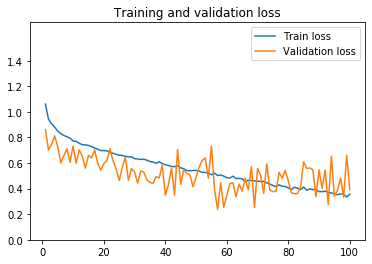

In [85]:
plt.plot(training_log['epoch'], training_log['train_loss'])
#plt.title("Loss on the training set over the epochs")
# plt.yticks(np.arange(0, 50, step = 5))
# plt.ylim(0,50)
#plt.show()

# Plotta accuracy över valideringsdatat:
plt.plot(training_log['epoch'], training_log['val_loss'])
plt.title("Training and validation loss")
plt.yticks(np.arange(0, 1.6, step = 0.2))
plt.ylim(0, 1.7)
plt.legend(['Train loss', 'Validation loss'], loc = 'upper right')
plt.show()


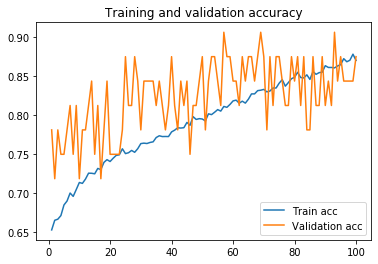

In [65]:
plt.plot(training_log['epoch'], training_log['train_acc'])
#plt.title("Loss on the training set over the epochs")
# plt.yticks(np.arange(0, 50, step = 5))
# plt.ylim(0,50)
#plt.show()

# Plotta accuracy över valideringsdatat:
plt.plot(training_log['epoch'], training_log['val_acc'])
plt.title("Training and validation accuracy")
#plt.yticks(np.arange(0, 1.1, step = 0.2))
#plt.ylim(0, max())
plt.legend(['Train acc', 'Validation acc'], loc = 'lower right')
plt.show()

In [66]:
max_train_acc = 100*max(training_log['train_acc'])

In [67]:
print(f'Max tränings-accuracy = {max_train_acc:.2f} %.')

Max tränings-accuracy = 87.81 %.


### Utvärdera modellen på validation- och test-set:

In [68]:
def evaluate_model(num_eval_images, data_loader, model):

    model.eval()

    start_eval_test_time = time.time()
    
    # Nedan för att vi inte ska uppdatera 
    # modellens vikter:

    with torch.no_grad():
        correct = 0
        # Antal iterationer = num_test_images / batchsz_test = x st.
    
        for X_test, y_test in data_loader:
            y_pred_test = model.forward(X_test)
            predicted = torch.max(input = y_pred_test, dim = 1)[1]
            correct += (predicted == y_test).sum()
    
        end_eval_test_time = time.time()
    
        eval_test_time = end_eval_test_time - start_eval_test_time

    print(f'Test accuracy: {correct.item()}/{num_eval_images} = {correct.item()*100/(num_eval_images):5.2f} %')
    print(f"\nEvaluation took {eval_test_time:.2f} seconds.")

In [69]:
num_test_images = len(val_loader.dataset)

evaluate_model(num_test_images, valid_dl, model)

Test accuracy: 966/1103 = 87.58 %

Evaluation took 3.91 seconds.


### Confusion matrix

In [70]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [71]:
def pytorch_confusion_matrix(num_classes, model, dataloader):
    model.eval()
    confusion_matrix = torch.zeros(num_classes, num_classes)
    
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            
            predictions = model.forward(inputs)
            _, preds = torch.max(predictions, 1)
            
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    
    return confusion_matrix

In [72]:
# Beräkningen på test-setet tar ca. 5 sek.
# på den stationära datorn med GPU med 4 workers, 
# och ca. 19 sek. med 8 workers.

start_cm_time = time.time()
cm_valid = pytorch_confusion_matrix(number_of_classes, model, valid_dl)

end_cm_time = time.time()

delta_cm_time = end_cm_time - start_cm_time

print(f'Beräkningen av CM tog {delta_cm_time:.2f}.')

Beräkningen av CM tog 4.15.


In [73]:
# Spara confusion matrix till en fil...

cm_file_suffice = ".pt"
cm_filename = "results/" + file_name + cm_file_suffice
torch.save(cm_valid, cm_filename)

In [74]:
# Ladda CM från en fil:

cm_valid = torch.load(cm_filename)

In [75]:
cm_valid_np = cm_valid.numpy()

In [76]:
np.set_printoptions(suppress=True)
print(cm_valid_np)

[[  9.   6.   6.   0.   6.   0.   3.]
 [  4.  22.   2.   0.   5.   0.   2.]
 [  1.   5.  44.   0.  28.   1.   9.]
 [  2.   1.   0.   1.   3.   0.   1.]
 [  1.   1.   7.   0. 864.   3.   7.]
 [  0.   0.   0.   0.   3.  10.   0.]
 [  2.   2.   5.   0.  18.   0.  19.]]


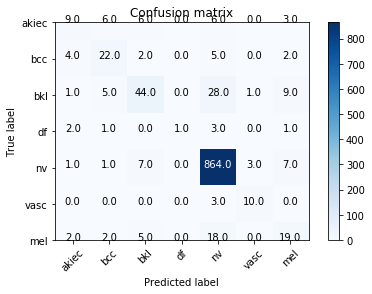

In [77]:
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(cm_valid_np, plot_labels)

### Precision och recall (precision & sensitivitet):

In [78]:
# Beräkna första radens summa:
sum_row_one = np.sum(cm_valid_np[0,:])

# Då blir t.ex. precision för label 1:
precision_label_one = cm_valid_np[0][0].item() / sum_row_one

print(f'Precision för label 1 = {precision_label_one:.3f}')

Precision för label 1 = 0.300


In [79]:
sum_row_one

30.0

In [80]:
# Motsvarande blir recall för label 1:

sum_col_one = np.sum(cm_valid_np[:,0])
recall_label_one = cm_valid_np[0][0] / sum_col_one

print(f'Recall för label 1 = {recall_label_one:.3f}')

Recall för label 1 = 0.474


In [81]:
list_of_labels = []
for label in lesion_type_dict.keys():
    list_of_labels.append(label)

list_of_labels.sort()

In [82]:
# Skapa en sammanställning över precision/recall för alla sju klasser.

# Precision:

print("Precision för respektive klass:")
counter = 0

for label in list_of_labels:
    
    sum_row_i = np.sum(cm_valid_np[counter, :])
    precision_i = cm_valid_np[counter, counter] / sum_row_i
    counter += 1
    print(f'{label:5}: {precision_i:.3f}')

# Recall:

print("\nRecall för respektive klass:")
counter = 0

for label in list_of_labels:
    
    sum_col_j = np.sum(cm_valid_np[:, counter])
    recall_j = cm_valid_np[counter, counter] / sum_col_j
    counter += 1
    print(f'{label:5}: {recall_j:.3f}')


Precision för respektive klass:
akiec: 0.300
bcc  : 0.629
bkl  : 0.500
df   : 0.125
mel  : 0.978
nv   : 0.769
vasc : 0.413

Recall för respektive klass:
akiec: 0.474
bcc  : 0.595
bkl  : 0.688
df   : 1.000
mel  : 0.932
nv   : 0.714
vasc : 0.463


### Visualisera modellens förutsägelser

In [297]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode = was_training)
                    return
        model.train(mode = was_training)

NameError: name 'class_names' is not defined

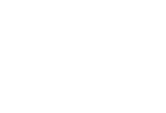

In [298]:
visualize_model(model, 4)